# <p style="text-align: center; color: red;"> Predicting Mineralogical Phases of Cement Clinker from Plant-level Data </p> 

# <p style="text-align: left; color: yellow;"> Sheikh Junaid Fayaz -- M3RG Lab -- Indian Institute of Technology, Delhi</p> 
# <p style="text-align: left; color: yellow;"> Date : 23 September 2024</p> 

# Importing Libraries

In [11]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from tqdm import tqdm
from matplotlib.ticker import AutoMinorLocator
import os as os
import pickle
import time
from sklearn.linear_model import Ridge
import numpy as np
import statistics
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ConstantKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor
from tqdm import tqdm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator 
from matplotlib import cm
import matplotlib.ticker as plticker 
import matplotlib.patches as patches
import math
import matplotlib

### Import dependencies for plotting

In [ ]:
# Add the Python path for loading ploting dependencies
sys.path.append(os.path.abspath("../../Ploting_dependencies"))

from new_plot import *          # Import from new_plot.py, #This line is throwing an error #Solved by commenting out some of the keys of rcParams()
from shadow.plot import *       # Import from shadow/plot.py
import subprocess

In [ ]:
print(matplotlib.__version__)

3.5.1


# Defining functions

### Error metric

In [13]:
from sklearn.metrics import r2_score, mean_absolute_error,mean_absolute_percentage_error
def get_score(base='Training', actual=0,predicted=0):
    r2 = r2_score(actual,predicted)
    mae = mean_absolute_error(actual,predicted)
    mape = mean_absolute_percentage_error(actual, predicted)
    return (r2.round(2),mae.round(2),(mape*100).round(2))

### Min, Avg & Max function

In [14]:
def average(min, max):
    mid = (min+max)/2
    if max-min <=1:
        mini = np.round(min,2)
        maxi = np.round(max,2)
        mid = np.round(mid,2)
    if max-min >1:
        mini = np.round(min,1)
        maxi = np.round(max,1)
        mid = np.round(mid,1)
    return(mini, mid, maxi)

### Common member function

In [15]:
def common_member(a, b):
    a_set = set(a)
    b_set = set(b)
 
    if (a_set & b_set):
        return(a_set & b_set)
    else:
        return({})

### Filtering function

Filters dataframe in the 0.1-99.9 percetile range

In [16]:
def filter_df(df):
    print(f'original length = {len(df)}')
    quantile_limit_values = []
    variable = df

    for column in variable:
        q_low = variable[column].quantile(0.0001)   # move dot 2 steps ahead, i.e., quantile(0.001) = 0.1 %
        q_hi  = variable[column].quantile(0.9999)
        quantile_limit_values.append((q_low,q_hi))


    count = 0
    for column in variable:
        q_low, q_hi = quantile_limit_values[count]
        variable = variable[(variable[column] < q_hi) & (variable[column] > q_low)]
        count +=1
        
    filtered = variable
    # filtered.reset_index(inplace=True)
    # filtered.drop(columns=['index'],inplace=True)
    print(f'length filtered = {len(filtered)}')
    return(filtered)
    

### Function for calculating MAPE of model predictions

In [17]:
def MPE(actual, prediction):
    error = []
    for i in range(len(prediction)):
        if actual[i] != 0:
            error.append((abs((actual[i]-prediction[i]))/abs(actual[i])*100))
        else:
            error.append((abs((actual[i]-prediction[i]))/abs(prediction[i])*100))
    x = 0
    for i in error:
        x += i
    x = x/len(prediction)
    mpe = round(x,2)
    return(mpe)

### Converts array to list

In [18]:
def array_to_list(x):
    mad = []
    for i in range(len(x)):
        mad.append(x[i][0])
    return(mad)

### Common member function

In [19]:
def common_member(a, b):
    a_set = set(a)
    b_set = set(b)
 
    if (a_set & b_set):
        return(a_set & b_set)
    else:
        print("No common elements")

### Function for parity plots

In [21]:
# run without Shadow
def parity_train_test(model, name):
    test_actual = y_test[y_test.columns[0]].to_list()
    train_actual = y_train[y_train.columns[0]].to_list()
    if name in ['Linear regression', 'Ridge']:
        test_pred = array_to_list(model.predict(X_test))
        train_pred = array_to_list(model.predict(X_train))
        [r2_train, mae_train, mape_train] = avg_train_results
        r2_test , mae_test, mape_test = get_score('Test',actual=y_test,predicted=model.predict(X_test))
    elif name in ['SVR', 'GPR', 'NN']:   
        test_pred_s = model.predict(X_test_s).reshape(-1,1)
        train_pred_s = model.predict(X_train_s).reshape(-1,1)

        # r2_train, mae_train, mape_train = get_score('Training',actual=y_train,predicted= scaler.inverse_transform(train_pred_s) )
        [r2_train, mae_train, mape_train] = avg_train_results
        r2_test , mae_test, mape_test  = get_score('Test',actual=y_test,predicted=scaler.inverse_transform(test_pred_s) )
        train_pred = array_to_list(scaler.inverse_transform(train_pred_s))
        test_pred = array_to_list(scaler.inverse_transform(test_pred_s)) 
    else:
        test_pred = list(model.predict(X_test))
        train_pred = list(model.predict(X_train))
        # r2_train, mae_train, mape_train = get_score('Training',actual=y_train,predicted=model.predict(X_train))
        [r2_train, mae_train, mape_train] = avg_train_results
        r2_test , mae_test, mape_test   = get_score('Test',actual=y_test,predicted=model.predict(X_test))
    print(f'Test: R^2 = {r2_test}, MAE = {mae_test}, MAPE = {mape_test}%')
    d = 0.4
    matplotlib.rcParams['axes.linewidth'] = 1
    style = 'normal'
    s = 25
    s1 = 15
    w =1
    minimum = 40
    maximum = 75

    fig, ax = plt.subplots(figsize=(5,5))
    _=plt.ylim(minimum, maximum)
    _=plt.xlim(minimum, maximum)
    _= plt.title(name, fontsize= s, fontweight = 'normal')
    _= plt.plot([minimum, maximum],[minimum, maximum], color = 'black', lw = 1.2, ls = (5,(10,3)))
    x1 = np.array([minimum, maximum])
    _= plt.plot(x1, 0.9*x1   , color = 'gray', lw = 1, ls = 'dotted')
    _= plt.plot(x1, 1.1*x1  , color = 'gray', lw = 1, ls = 'dotted')
    _= plt.fill_between(x1, 0.9*x1, 1.1*x1 ,alpha = 0.04, color = 'green'  )

    _= plt.scatter(train_actual,train_pred,color = ['white'] , s=35, linewidth = 1,edgecolors='red', marker = '^' ,label = 'MAPE$_{train}$: '+f'{mape_train:.2f}'+'%')
    _= plt.scatter(train_actual,train_pred,color = ['firebrick'] , s=35,alpha = 0.1, marker ='^',)

    _= plt.scatter(test_actual,test_pred,color = ['white'] , s = 35, linewidth = 1,edgecolors='blue', marker= 'o', label = 'MAPE$_{test}$: '+f'{mape_test:.2f}' +'%')
    _= plt.scatter(test_actual,test_pred,color = ['darkblue'] , s=35,alpha = 0.1, marker = 'o')

    _= plt.text(0.67,0.44,'- 10%',  transform=ax.transAxes,fontsize= s1, fontweight ='normal')
    _= plt.text(0.55,0.83, '+ 10%', transform=ax.transAxes, fontsize= s1, fontweight ='normal')

    X1 = [50, 60, 70]
    _= plt.xticks(X1, X1,rotation = 0, fontweight = style, fontsize = s)
    _= plt.yticks(X1,X1,rotation = 0, fontweight = style, fontsize = s)
    _= ax.tick_params('both', length=10, width=w, which='major')
    _= ax.tick_params('both', length=5, width=w, which='minor')
    _= plt.tick_params(axis="both", which="both", direction = 'in', right = True, left = True, top = True)
    _= plt.xlabel('Measured alite (wt. %)', fontsize= s, fontweight = 'normal')
    _= plt.ylabel('Predicted alite (wt. %)', fontsize= s, fontweight = 'normal')

    _= plt.legend(labelspacing = 0, loc = 'lower right', frameon = True,prop = {'weight' : 'normal', 'size' : 16.5},
                    borderpad=0.2,   # Adjust this to control space between the text and the border
                    handlelength=0.5,  # Adjust this to shorten the space before the legend text
                    handletextpad=0.5 ) # Adjust this to remove space between the legend marker and text)
    # # incet test
    left, bottom, width, height = [0.15, 0.64, 0.2, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])
    p = np.array(test_actual)
    a = np.array(test_pred)
    std=np.std(p - a)
    mean=np.mean(p - a)
    xx=mean-2*std
    yy = 0
    _=y1,x,_ = ax2.hist(p - a, bins = int(1+3.3*np.log(len(p-a))) ,color='white',range = [-4*std, 4*std] )
    rec = patches.Rectangle((xx,yy),4*std, np.max(y1), facecolor ='goldenrod', alpha = 0.25)
    ax2.add_patch(rec)
    _= plt.axvline(x = xx, color = 'goldenrod', lw =0.6, ls = '--')
    _= plt.axvline(x = xx+4*std, color = 'goldenrod', lw =0.6, ls = '--')
    y1,x,_ = ax2.hist(p - a, bins = int(1+3.3*np.log(len(p-a))) ,color='white',range = [-4*std, 4*std] )
    y1,x,_ = ax2.hist(p - a, bins = int(1+3.3*np.log(len(p-a))) ,color='darkblue',range = [-4*std, 4*std], alpha = 0.78)

    ax2.set_ylim(0,np.max(y1))
    ax2.xaxis.set_major_locator(plt.MaxNLocator(3))
    xlabel_ax2 = ax2.get_xticklabels()
    ax2.yaxis.tick_right()
    # ax2.yaxis.set_tick_params(labelsize =10,weight = 'normal')
    _= plt.xticks(fontweight = style, fontsize = s1)
    _= plt.yticks(fontweight = style, fontsize = s1)
    _= ax2.xaxis.set_tick_params(labelsize =s1)  #11.8
    # _= ax2.yaxis.set_tick_params(labelsize =12)
    _= ax2.tick_params('both', length=10, width=w, which='major', direction = 'in')
    _= ax2.tick_params('both', length=5, width=w, which='minor', direction = 'in')
    ax2.yaxis.set_label_position("right")
    _=ax2.set_ylabel(r"$\nu$",fontsize=s1, fontweight = style, labelpad = 0, fontname='DejaVu Sans')
    _=ax2.set_xlabel(r'$\epsilon$',fontsize=s1+2, fontweight = style, labelpad = 0)

    # incet train
    left, bottom, width, height = [0.15, 0.19, 0.2, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])
    p = np.array(train_pred)
    a = np.array(train_actual)
    std=np.std(p - a)
    mean=np.mean(p - a)
    xx=mean-2*std
    yy = 0
    y1,x,_ = ax2.hist(p - a, bins = int(1+3.3*np.log(len(p-a))) ,color='white',range = [-4*std, 4*std] )
    rec = patches.Rectangle((xx,yy),4*std, max(y1), facecolor ='goldenrod', alpha = 0.25)
    ax2.add_patch(rec)
    _= plt.axvline(x = xx, color = 'goldenrod', lw =0.6, ls = '--')
    _= plt.axvline(x = xx+4*std, color = 'goldenrod', lw =0.6, ls = '--')
    _=y1,x,_ = ax2.hist(p - a, bins = int(1+3.3*np.log(len(p-a))) ,color='white',range = [-4*std, 4*std] )
    _=y1,x,_ = ax2.hist(p - a, bins = int(1+3.3*np.log(len(p-a))) ,color='firebrick',range = [-4*std, 4*std], alpha = 1)

    _=ax2.set_ylim(0,max(y1))
    _=ax2.xaxis.set_major_locator(plt.MaxNLocator(3))
    _=xlabel_ax2 = ax2.get_xticklabels()
    _=ax2.yaxis.tick_right()
    # ax2.yaxis.set_tick_params(labelsize =10,weight = 'normal')
    _= plt.xticks(fontweight = style, fontsize = s1)
    _= plt.yticks(fontweight = style, fontsize = s1)
    _= ax2.xaxis.set_tick_params(labelsize =s1)  #11.8
    _= ax2.yaxis.set_tick_params(labelsize =s1)
    _= ax2.tick_params('both', length=10, width=w, which='major')
    _= ax2.tick_params('both', length=5, width=w, which='minor')
    _=ax2.yaxis.set_label_position("right")
    _=ax2.set_ylabel(r"$\nu$",fontsize=s1, fontweight = style, labelpad = 0, fontname='DejaVu Sans')
    # plt.savefig(f'/Users/sheikhjunaidfayaz/Documentxs/saved_items/clinker_phase_prediction_paper/parity_all_inputs/alite/{name}.tiff',format='tiff', bbox_inches = 'tight',dpi=1200)
    _=plt.show()

## Function for NN parity (HPC data)

In [ ]:
def parity_custom(train_actual, train_pred ,test_actual , test_prediction , title):
    fig, ax = plt.subplots()
    mpe = MPE(test_actual, test_prediction)
    minimum1 = round(min(test_actual + test_prediction), 5)
    maximum1 = round(max(test_actual + test_prediction), 5)     

    minimum2 = round(min(train_actual + train_pred), 5)
    maximum2 = round(max(train_actual + train_pred), 5)
    minimum = min(minimum1, minimum2)
    maximum = max(maximum1, maximum2)
    maximum = math.ceil(maximum)
    minimum = math.floor(minimum)

    _= plt.scatter(test_actual,test_prediction,color = ['firebrick'] , s = 13)
    _= plt.plot([minimum, minimum],[minimum, minimum], color = 'white', lw = 0)
    _= plt.plot([minimum, maximum],[minimum, maximum], color = 'black', lw = 1)
    
    _= plt.xticks(rotation = 0, fontweight = 'normal', fontsize = 15)
    _= plt.yticks(fontweight = 'normal', fontsize = 15)
   
    box = ('$|MPE|_{test}$ ='+f' {mpe}')
    _= ax.text( 0.62,0.25,box, transform=ax.transAxes, linespacing=1 ,fontsize=15,verticalalignment='top', fontweight='normal')
    _= plt.xlabel('Measured alite, $C_{3}S$ (%)', fontweight = 'normal', fontsize = 15)
    _= plt.ylabel('Predicted alite, $C_{3}S$ (%)', fontweight = 'normal', fontsize = 15)
    _= plt.title(title, fontweight = 'normal', fontsize = 16)
    _= plt.legend([f'Test  ($R^2$ = 0.9)', f'Train ($R^2$ = 0.91)'],labelspacing = 0, loc = 'lower right', frameon = False,prop = {'weight' : 'normal', 'size' : 15})
    _= ax.tick_params('both', length=10, width=1, which='major')
    _= ax.tick_params('both', length=5, width=1, which='minor')

    # incet
    left, bottom, width, height = [0.15, 0.64, 0.22, 0.22]
    ax2 = fig.add_axes([left, bottom, width, height])
    p = np.array(test_prediction)
    a = np.array(test_actual)
    std=np.std(p - a)
    mean=np.mean(p - a)
    xx=mean-2*std
    yy = 0
    y1,x,_ = ax2.hist(p - a, bins = int(1+3.3*np.log(len(p-a))) ,color='black',range = [-4*std, 4*std] )
    rec = patches.Rectangle((xx,yy),4*std, max(y1), facecolor ='r',edgecolor='r', alpha = 0.2)
    ax2.add_patch(rec)
    ax2.set_ylim(0,max(y1))
    ax2.xaxis.set_major_locator(plt.MaxNLocator(3))
    xlabel_ax2 = ax2.get_xticklabels()
    ax2.yaxis.tick_right()
    _= plt.xticks(fontweight = 'normal')
    _= plt.yticks(fontweight = 'normal')
    _= ax2.xaxis.set_tick_params(labelsize =11.8)
    _= ax2.yaxis.set_tick_params(labelsize =11.8)
    _= ax2.tick_params('both', length=10, width=1, which='major')
    _= ax2.tick_params('both', length=5, width=1, which='minor')
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel('\u03BD',fontsize=15, fontweight = 'normal', labelpad = 0)
    ax2.set_xlabel(r'$\epsilon$',fontsize=18, fontweight = 'normal', labelpad = 0)

# Defining variables

### Naming process parameters

In [22]:
pp_naming_list = [
'Exit temp C1A ($^o C$)',
'Exit temp C1B ($^o C$)',
'Exit temp C2 ($^o C$)',
'Exit temp C3 ($^o C$)',
'Exit temp C4 ($^o C$)',
'Exit temp C5 ($^o C$)',
'PH gas outlet temp($^o C$)',
'O$_2$ in raw gas at PH outlet (%)',
'Temp of KF to PH ($^o C$)',
'KF flow rate to PH (t/h)',
'Flue gas exit temp at calciner \n($^o C$)',
'Flue gas O$_2$ content at calciner outlet\n(%)',
'Solid\'s outlet temp at kiln inlet ($^o C$)',
'Calciner\'s fuel consumption (t/h)',
'O$_2$ in the kiln gas at kiln inlet (%)',
'HM temp of lowest cyclone ($^o C$)',
'Total cooling air ($x10^4$ $Am^3/h)$',  
'III Air temp at CC outlet ($^o C$)',
'Clinker production (t/h)',
'Total flow of gas entering GCT (CFM)',
'Temp of gas entering GCT ($^o C$)',
'Spray water used in GCT $(m^3/h)$',
'GCT outlet temp ($^o C$)',
'Temp of gas entering the main fan ($^o C$)',
'Raw mill el. Consumption (kW)',
'Pre-calciner outlet pressure (mb)',
'Exit pressure C1A (mb)',
'Exit pressure C1B (mb)',
'Exit pressure C2 (mb)',
'Exit pressure C3 (mb)',
'Exit pressure C4 (mb)',
'Exit pressure C5 (mb)',
'Raw mill fan inlet pressure at pt 1\n(mb)',
'Raw mill fan inlet pressure at pt 2\n(mb)'
]

# Direcly reading timestamp matched df (now_2)

In [ ]:
now_2 = pd.read_excel('now_2.xlsx') # timestamp matched PP, KF, HM, CLk without filtering
new = now_2.iloc[:,list(range(0,34))+list(range(59,62))] # this new has only PP and clk phases
new.to_excel('./Emission/combined_old.xlsx', index = False) # Saving new file

new_pp = new.dropna(axis=0, how='any',thresh = None, inplace = False) # remove NaN form the timestamp matched file
new_pp.shape

final = filtered[((filtered['alite']< 71) & (filtered['alite']> 45 )) & ((filtered['belite']< 25) & (filtered['belite']> 5 )) & ((filtered['ferrite']< 17) & (filtered['ferrite']> 8.41 ))]
# domain based filters on clinker phases

# Filtering the combined dataframe

In [7]:
now = filter_df(now_2).dropna(axis=0, how='any',thresh = None, inplace = False) 
# now is with 0.1 to 99.9 filtering and removing NaN

original length = 14778
length filtered = 8680


Domain knowledge based filtering for anomalious values

In [8]:
now = now[(now['na2o'] <= 0.3) & 
           (now['cl'] <= 0.1) & 
           (now['cl1'] <= 0.075) & 
           (now['cao1'] >= 41) & 
           (now['so32'] < 2) & 
           (now['k2o2'] < 3) & 
           (now['cl2'] < 2) & 
           (now['alite2'] < 20) & 
           (now['belite2'] < 7.5) & 
           (now['ferrite2'] < 7)]

now= now[((now['alite'] < 71) & (now['alite'] > 45)) & 
            ((now['belite'] < 25) & (now['belite'] > 5)) & 
            ((now['ferrite'] < 17) & (now['ferrite'] > 8.41))]  # Completely filtered data

# Timestamp matched, unfiltered data

In [ ]:
pp = now_2.iloc[:,:34]
that = now_2.iloc[:,34:62] # that is unfiltered
hrm = that.iloc[:,9:-12]
frm = that.iloc[:,:9]
clinker = that.iloc[:,-12:]

In [ ]:
frm.describe().loc[['min', 'max', 'mean' , 'std']].round(2).T.to_excel('/Users/sheikhjunaidfayaz/Desktop/frm.xlsx')
hrm.describe().loc[['min', 'max', 'mean' , 'std']].round(2).T.to_excel('/Users/sheikhjunaidfayaz/Desktop/hrm.xlsx')
clinker.describe().loc[['min', 'max', 'mean' , 'std']].round(2).T.to_excel('/Users/sheikhjunaidfayaz/Desktop/clinker.xlsx')
pp.describe().loc[['min', 'max', 'mean' , 'std']].round(2).T.to_excel('/Users/sheikhjunaidfayaz/Desktop/pp.xlsx')

# Timestamp matched, filtered data

In [ ]:
pp_filtered = now.iloc[:,:34]
that1 = now.iloc[:,34:]
hrm_filtered = that1.iloc[:,9:-12]
frm_filtered = that1.iloc[:,:9]
clinker_filtered = that1.iloc[:,-12:]

In [ ]:
naming_list_frm = ['$CaO$', '$SiO_2$', '$Al_2O_3$','$Fe_2O_3$', 'MgO', '$SO_3$', '$K_2O$', '$Na_2O$', 'Cl']
naming_list = ['$CaO$', '$SiO_2$', '$Al_2O_3$','$Fe_2O_3$', 'MgO', '$SO_3$', '$K_2O$', '$Na_2O$', 'Cl', '$TiO_2$', 'Alite, $C_3$S',  'Belite, C$_2$S',  'Ferrite, C$_4$AF', 'Quartz', 'Calcite' , 'Free lime']
naming_list_hrm =  ['$SO_3$', '$K_2O$', '$Na_2O$', 'Cl', 'Alite, $C_3$S',  'Belite, C$_2$S',  'Ferrite, C$_4$AF']
naming_list_clk = ['$CaO$', '$SiO_2$', '$Al_2O_3$','$Fe_2O_3$', 'MgO', '$SO_3$', '$K_2O$', '$Na_2O$', 'Cl', 'Alite, $C_3$S',  'Belite, C$_2$S',  'Ferrite, C$_4$AF']

In [ ]:
pp = that1.iloc[:,:34] # pp = pp_filtered
pp['Total cooling air'] = list(pp['Total cooling air'].div(10000))

# Ploting distribution


### Reading data for visualizing alite distribution

In [4]:
db2 = pd.read_csv('db2_clinker.csv')
db2 = db2[db2['material_type'] == 'clinker']

phase = 'alite'
values_raw = db2[phase].to_list()
len(values_raw)

14985

### Setting rcParams for the plot

In [694]:
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

### Visualizing the distribution on a timescale

(-651.0, 15636.0)

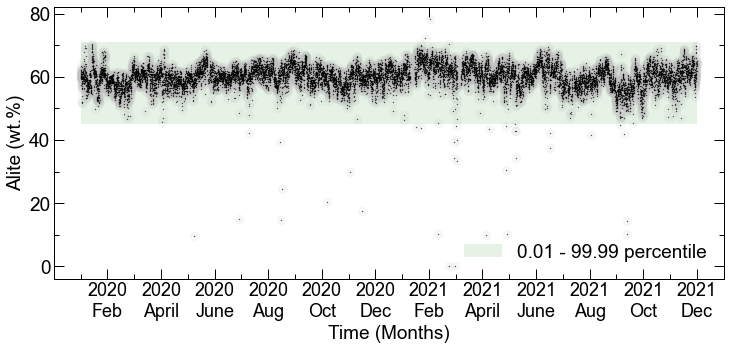

In [695]:
s = 19                                      
matplotlib.rcParams['axes.linewidth'] = 1
w =1

lower_lim = 45
higher_lim = 71
figure, ax = plt.subplots(figsize=(12,5))  #dimgray
# ax.plot([i+1 for i in range(len(values2))],values2, label = 'NO$_{x}$ emission profile', color = 'darkblue' )


ax.xaxis.set_major_locator(ticker.MultipleLocator(91527.56))
ax.set_xlim(- int(len(values_raw)/23),len(values_raw)+ int(len(values_raw)/23))

a, b, c = int(len(values_raw)/23),len(values_raw), int((len(values_raw)/23)*2)
_= ax.set_xticks([i for i in range(a,b,c)], labels = ['2020\nFeb', '2020\nApril', '2020\nJune', '2020\nAug', '2020\nOct', '2020\nDec','2021\nFeb', '2021\nApril', '2021\nJune', '2021\nAug', '2021\nOct', '2021\nDec'], rotation = 0, fontsize= 18, fontweight= 'normal')
_= plt.yticks([0,20,40,60,80],[0,20,40,60,80], rotation = 0, fontsize=s, fontweight= 'normal')
#
_= ax.tick_params(which = 'major', width= 1, length =10,)
_= ax.tick_params(which = 'minor', width= 1, length =5)
_= ax.tick_params(axis='x', direction ='in', which = 'both')
_= ax.tick_params(axis='y', direction ='in', which = 'both')
_= ax.tick_params(axis='y', which='major', right= True)
_= ax.tick_params(axis='y', which='minor', right= True)
_= ax.tick_params(axis='y', which='major', left= True)
_= ax.tick_params(axis='y', which='minor', left= True)
_= ax.tick_params(axis='x', which='major', top = True)
_= ax.tick_params(axis='x', which='minor', top = True)
_= ax.set_ylabel('Alite (wt.%)', fontsize=s, fontweight='normal')
_= ax.set_xlabel('Time (Months)', fontsize=s, fontweight='normal')
_= ax.xaxis.set_minor_locator(AutoMinorLocator(2))
_= ax.yaxis.set_minor_locator(AutoMinorLocator(2))
x_left, y_left, width, height = (0,lower_lim,len(values_raw),(higher_lim-lower_lim))
rect=mpatches.Rectangle((x_left,y_left),width,height, 
                        facecolor = "green",
                        alpha = 0.1,
                        label = f'0.01 - 99.99 percentile')    #({lower_lim}% - {higher_lim}%)
_= plt.gca().add_patch(rect)

ax.scatter([i+1 for i in range(len(values_raw))],values_raw,  color = 'silver', alpha = 0.1,s = 70)  
ax.scatter([i+1 for i in range(len(values_raw))],values_raw,color = 'black',s = 0.1)   #, alpha = 1, edgecolors='black', linewidth =1
_= ax.legend(prop= {'weight':'normal', 'size':s}, loc= 'lower right', frameon= False)
plt.savefig('/Users/sheikhjunaidfayaz/Documents/Papers/Innovandi/Phase_prediction/Figures/alite_dist_1.tiff',format='tiff', dpi=1200)
plt.show()


### Frequency distribution

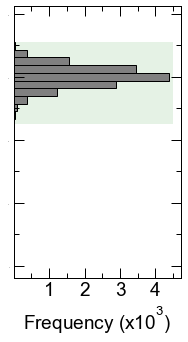

In [696]:
s = 19                                      
matplotlib.rcParams['axes.linewidth'] = 1
w =1

fig, ax = plt.subplots(figsize=(3,5))

_= plt.yticks(fontsize=0, fontweight='normal')
_= plt.xticks([1000, 2000, 3000, 4000],[1,2,3,4],fontsize=s, fontweight='normal')
_= ax.tick_params(which = 'major', width= 1, length = 10)
_= ax.tick_params(which = 'minor', width= 1, length =5)
_= ax.tick_params(axis='x', direction ='in', which = 'both')
_= ax.tick_params(axis='y', direction ='in', which = 'both')
_= ax.tick_params(axis='y', which='major', right= True)
_= ax.tick_params(axis='y', which='minor', right= True)
_= ax.tick_params(axis='y', which='major', left= True)
_= ax.tick_params(axis='y', which='minor', left= True)
_= ax.tick_params(axis='x', which='major', top = True)
_= ax.tick_params(axis='x', which='minor', top = True)

_= ax.xaxis.set_minor_locator(AutoMinorLocator(2))
_= ax.yaxis.set_minor_locator(AutoMinorLocator(2))
_= ax.set_xlabel('Frequency', fontsize = s)
x_left, y_left, width, height = (0,lower_lim,4500,(higher_lim-lower_lim))
rect=mpatches.Rectangle((x_left,y_left),width,height, 
                        facecolor = "green",
                        alpha = 0.1,
                        label = f'({lower_lim}% - {higher_lim}%)')
_= plt.gca().add_patch(rect)
_= ax.hist(values_raw, orientation = 'horizontal', color = 'gray',bins= int(1+3.3*np.log(len(values_raw)) ), ec='k')
_= ax.set_xlabel('Frequency (x10$^3$)', fontsize = s, fontweight= 'normal')
plt.savefig('/Users/sheikhjunaidfayaz/Documents/Papers/Innovandi/Phase_prediction/Figures/alite_dist_2.tiff',format='tiff', dpi=1200)
plt.show()

### Frequency distribution for filtered data

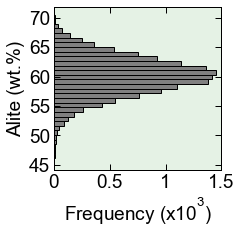

In [697]:
values1_filtered = [i for i in values_raw if i >=45 and  i <=71 ]
sz = 19                                      
matplotlib.rcParams['axes.linewidth'] = 1
w =1

fig, ax = plt.subplots(figsize=(3,3))
_=plt.xlim(0,1500)
_= ax.hist(values1_filtered, orientation = 'horizontal', color = 'gray',bins= int(1+3.3*np.log(len(values1_filtered)) ), ec= 'k')
_= plt.yticks(fontsize=15, fontweight='normal')
_= plt.xticks([0,500,1000,1500],[0,0.5,1,1.5],fontsize=s, fontweight='normal')
_= plt.yticks([45,50,55,60,65,70],[45,50,55,60,65,70],fontsize=sz, fontweight='normal')
_= ax.tick_params(which = 'major', width= 1, length =6)
_= ax.tick_params(which = 'minor', width= 1, length =0)
_= ax.tick_params(axis='x', direction ='in', which = 'both')
_= ax.tick_params(axis='y', direction ='in', which = 'both')
_= ax.tick_params(axis='y', which='major', right= True)
_= ax.tick_params(axis='y', which='minor', right= True)
_= ax.tick_params(axis='y', which='major', left= True)
_= ax.tick_params(axis='y', which='minor', left= True)
_= ax.tick_params(axis='x', which='major', top = True)
_= ax.tick_params(axis='x', which='minor', top = True)
_= plt.xticks(fontsize=sz, fontweight='normal', rotation = 0)
_= ax.set_xlabel('Frequency', fontsize = sz)
_= plt.yticks(fontsize=sz)
_= ax.patch.set_facecolor('green')
_= ax.patch.set_alpha(0.1)
_= ax.set_ylabel('Alite (wt.%)', fontsize=sz, fontweight='normal')
_= ax.set_xlabel('Frequency (x10$^3$)', fontsize = sz, fontweight= 'normal')
plt.savefig('/Users/sheikhjunaidfayaz/Documents/Papers/Innovandi/Phase_prediction/Figures/alite_dist_3.tiff',format='tiff', dpi=1200)
plt.show()

# Read files here

In [ ]:
db2 = pd.read_csv('./Data/db2_clinker.csv')

hot_meal = db2[db2['material_type'] == 'hot_meal']
kiln_feed = db2[db2['material_type'] == 'kiln_feed']
clk = db2[db2['material_type'] == 'clinker']

hot_meal.drop(columns= ['sample_date', 'sample_id_plant','material_type' ], inplace = True)
kiln_feed.drop(columns= ['sample_date', 'sample_id_plant','material_type' ], inplace = True)
clk.drop(columns= ['sample_date', 'sample_id_plant','material_type' ], inplace = True)

# Data visualization

### Corelation matrix

In [ ]:
df = X.copy(deep = True)
corr_df = df.corr(method = 'pearson')
fig, ax = plt.subplots(figsize=(30,30))
mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)
sns.heatmap(corr_df, mask=mask_ut,annot = True,xticklabels = False, yticklabels = False,  cmap=sns.diverging_palette(230, 20, as_cmap=True))

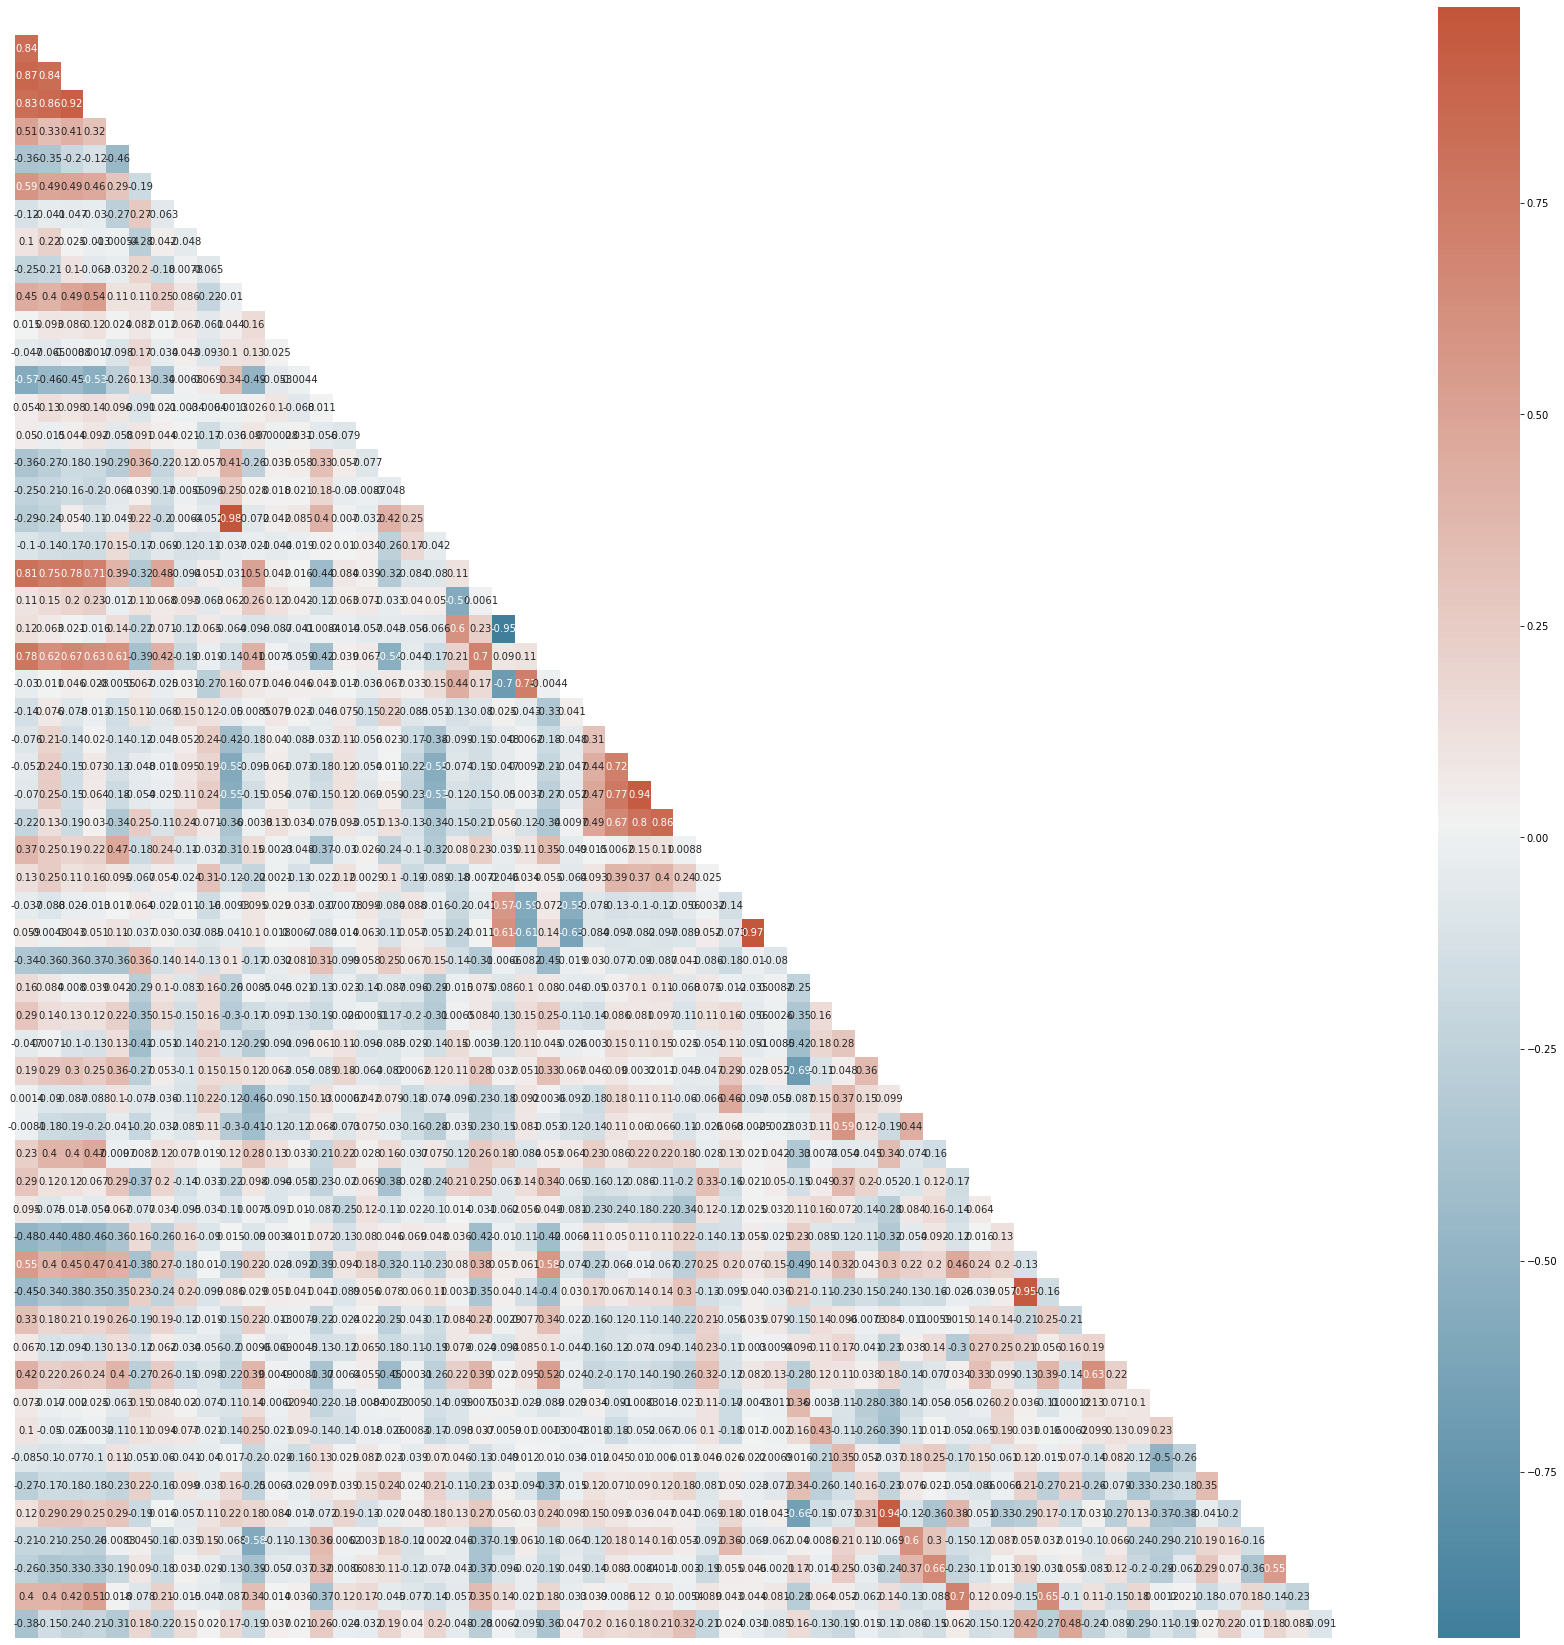

# Visualizing the train and test set



The filtered parent set is partioned into train and test set

In [716]:
df = that1[['alite', 'belite','ferrite']]  # df has the output phases
X_train, X_test, y_train, y_test= train_test_split(that1,df,test_size=0.20,random_state=100) # earlier 100, # this needs df and that1

train = y_train['alite'].to_list()  # for visualizing alite
test = y_test['alite'].to_list()
raw = df['alite'].to_list()

# train = y_train['belite'].to_list()  # for visualizing belite
# test = y_test['belite'].to_list()
# raw = df['belite'].to_list()

# phase = 'ferrite'                    # for visualizing ferrite
# train = y_train[phase].to_list()
# test = y_test[phase].to_list()
# raw = df[phase].to_list()

mean = np.round(df[phase].describe()['mean'], 1)
min =  np.round(df[phase].describe()['min'], 1)
max =  np.round(df[phase].describe()['max'], 1)
std =  np.round(df[phase].describe()['std'], 1)


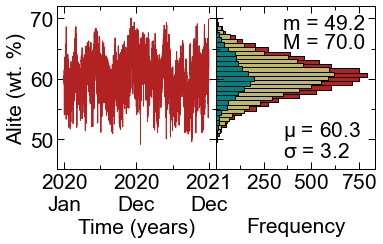

In [707]:
matplotlib.rcParams['axes.linewidth'] = 1
s = 21
fig, ax = plt.subplots(1,2,figsize=(5.7,3),squeeze = False, sharey='col' )
plt.subplots_adjust(wspace=0)

_= ax[0,0].set_ylim(45,72)
_= ax[0,0].set_yticks([50,60,70],[50,60,70],fontsize = s, fontweight = 'normal')
_=ax[0,0].set_xlabel('Time (years)', fontweight = 'normal', fontsize = s)
_=ax[0,0].set_xticks([0,len(raw)/2 ,len(raw)], labels = ['2020\nJan','2020\nDec' ,'2021\nDec'], fontsize = s, fontweight= 'normal')
_=ax[0,0].plot(np.arange(0,len(raw)), raw, linewidth=1, color= 'firebrick')
_= ax[0,0].tick_params(which = 'major', width= 1, length =7)
_= ax[0,0].tick_params(which = 'minor', width= 1, length =4)
_= ax[0,0].tick_params(axis='x', direction ='in', which = 'both')
_= ax[0,0].tick_params(axis='y', direction ='in', which = 'both')
_= ax[0,0].tick_params(axis='y', which='major', right= True)
_= ax[0,0].tick_params(axis='y', which='minor', right= True)
_= ax[0,0].tick_params(axis='y', which='major', left= True)
_= ax[0,0].tick_params(axis='y', which='minor', left= True)
_= ax[0,0].tick_params(axis='x', which='major', top = True)
_= ax[0,0].tick_params(axis='x', which='minor', top = True)
_= ax[0,0].set_ylabel('Alite (wt. %)', fontsize=s, fontweight='normal')
# _= plt.ylim(10.5,17.5)
_= plt.xticks([250,500,750],fontsize = s, fontweight = 'normal')
_= plt.yticks(fontsize = 0, fontweight = 'normal')
_= ax[0,1].set_xlabel('Frequency', fontsize=s, fontweight='normal', labelpad = 25)
_= ax[0,1].set_ylim(45,72)
# _= ax.set_xlabel('$Ferrite, C_{4}AF$ (%)', fontsize=s, fontweight='normal')
_= ax[0,1].tick_params(which = 'major', width= 1, length =7)
_= ax[0,1].tick_params(which = 'minor', width= 1, length =4)
_= ax[0,1].tick_params(axis='x', direction ='in', which = 'both')
_= ax[0,1].tick_params(axis='y', direction ='in', which = 'both')
_= ax[0,1].tick_params(axis='y', which='major', right= True)
_= ax[0,1].tick_params(axis='y', which='minor', right= True)
_= ax[0,1].tick_params(axis='y', which='major', left= True)
_= ax[0,1].tick_params(axis='y', which='minor', left= True)
_= ax[0,1].tick_params(axis='x', which='major', top = True)
_= ax[0,1].tick_params(axis='x', which='minor', top = True)

_ = plt.hist(raw, bins = int(1+3.3*np.log(len(raw))), ec= 'k', color = 'firebrick', density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
_ = plt.hist(train, bins = int(1+3.3*np.log(len(train))), ec= 'k', color = 'darkkhaki', density = False, label = 'train set', alpha = 1, orientation= 'horizontal')
_ = plt.hist(test, bins = int(1+3.3*np.log(len(test))), ec= 'k', color = 'teal', density = False, label = 'test set', alpha = 1, orientation= 'horizontal')

_= plt.text(350,47, f'$\mu$ = {mean}\n$\sigma$ = {std}', linespacing=1 ,fontsize=s, fontweight='normal') #verticalalignment='bottom'
_= plt.text(350,65, f'm = {min}\nM = {max}', linespacing=1 ,fontsize=s, fontweight='normal')
plt.savefig('/Users/sheikhjunaidfayaz/Documents/Papers/Innovandi/Phase_prediction/Figures/alite_stat.tiff',format='tiff', dpi=1200)
_= plt.show()

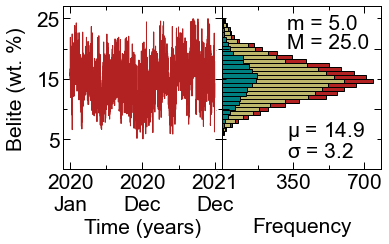

In [715]:
matplotlib.rcParams['axes.linewidth'] = 1
s = 21
fig, ax = plt.subplots(1,2,figsize=(5.7,3),squeeze = False, sharey='col' )
plt.subplots_adjust(wspace=0)

_= ax[0,0].set_ylim(0,27)
_= ax[0,0].set_yticks([5,15,25],[5,15,25],fontsize = s, fontweight = 'normal')
_=ax[0,0].set_xlabel('Time (years)', fontweight = 'normal', fontsize = s)
_=ax[0,0].set_xticks([0,len(raw)/2 ,len(raw)], labels = ['2020\nJan','2020\nDec' ,'2021\nDec'], fontsize = s, fontweight= 'normal')
_=ax[0,0].plot(np.arange(0,len(raw)), raw, linewidth=1, color= 'firebrick')
_= ax[0,0].tick_params(which = 'major', width= 1, length =7)
_= ax[0,0].tick_params(which = 'minor', width= 1, length =4)
_= ax[0,0].tick_params(axis='x', direction ='in', which = 'both')
_= ax[0,0].tick_params(axis='y', direction ='in', which = 'both')
_= ax[0,0].tick_params(axis='y', which='major', right= True)
_= ax[0,0].tick_params(axis='y', which='minor', right= True)
_= ax[0,0].tick_params(axis='y', which='major', left= True)
_= ax[0,0].tick_params(axis='y', which='minor', left= True)
_= ax[0,0].tick_params(axis='x', which='major', top = True)
_= ax[0,0].tick_params(axis='x', which='minor', top = True)
_= ax[0,0].set_ylabel('Belite (wt. %)', fontsize=s, fontweight='normal',labelpad = 10)
# _= plt.text(250,4.4, f'Mean,$\mu$ = {mean}\nStd dev,$\sigma$ = {std}', linespacing=1 ,fontsize=s, fontweight='normal') #verticalalignment='bottom'
# _= plt.text(250,20.5, f'Min = {min}\nMax = {max}', linespacing=1 ,fontsize=s, fontweight='normal')

_= ax[0,1].set_ylim(0,27)
_= plt.xticks([350, 700],fontsize = s, fontweight = 'normal')
_= plt.yticks(fontsize = 0, fontweight = 'normal')
_= ax[0,1].set_xlabel('Frequency', fontsize=s, fontweight='normal' ,labelpad = 25)
# _= ax.set_xlabel('$Ferrite, C_{4}AF$ (%)', fontsize=s, fontweight='normal')
_= ax[0,1].tick_params(which = 'major', width= 1, length =7)
_= ax[0,1].tick_params(which = 'minor', width= 1, length =4)
_= ax[0,1].tick_params(axis='x', direction ='in', which = 'both')
_= ax[0,1].tick_params(axis='y', direction ='in', which = 'both')
_= ax[0,1].tick_params(axis='y', which='major', right= True)
_= ax[0,1].tick_params(axis='y', which='minor', right= True)
_= ax[0,1].tick_params(axis='y', which='major', left= True)
_= ax[0,1].tick_params(axis='y', which='minor', left= True)
_= ax[0,1].tick_params(axis='x', which='major', top = True)
_= ax[0,1].tick_params(axis='x', which='minor', top = True)

_ = plt.hist(raw, bins = int(1+3.3*np.log(len(raw))), ec= 'k', color = 'firebrick', density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
_ = plt.hist(train, bins = int(1+3.3*np.log(len(train))), ec= 'k', color = 'darkkhaki', density = False, label = 'train set', alpha = 1, orientation= 'horizontal')
_ = plt.hist(test, bins = int(1+3.3*np.log(len(test))), ec= 'k', color = 'teal', density = False, label = 'test set', alpha = 1, orientation= 'horizontal')
# _= plt.text(250,4.4, f'Mean,$\mu$ = {mean}\nStd dev,$\sigma$ = {std}', linespacing=1 ,fontsize=s, fontweight='normal') #verticalalignment='bottom'
# _= plt.text(250,20.5, f'Min = {min}\nMax = {max}', linespacing=1 ,fontsize=s, fontweight='normal')
# _= ax.legend(prop= {'weight':'normal', 'size':12}, frameon= False,loc= 'upper left' )  #bbox_to_anchor=(1.02, 1.02)
_= plt.text(320,2, f'$\mu$ = {mean}\n$\sigma$ = {std}', linespacing=1 ,fontsize=s, fontweight='normal') #verticalalignment='bottom'
_= plt.text(320,20, f'm = {min}\nM = {max}', linespacing=1 ,fontsize=s, fontweight='normal')
plt.savefig('/Users/sheikhjunaidfayaz/Documents/Papers/Innovandi/Phase_prediction/Figures/belite_stat.tiff',format='tiff', dpi=1200)
plt.show()
                                            

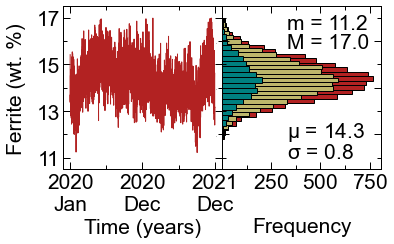

In [737]:
matplotlib.rcParams['axes.linewidth'] = 1
s = 21
fig, ax = plt.subplots(1,2,figsize=(5.7,3),squeeze = False, sharey='col' )
plt.subplots_adjust(wspace=0)

_= ax[0,0].set_ylim(10.5,17.5)
_= ax[0,0].set_yticks([11,13,15,17],[11,13,15,17],fontsize = s, fontweight = 'normal')
_=ax[0,0].set_xlabel('Time (years)', fontweight = 'normal', fontsize = s)
_=ax[0,0].set_xticks([0,len(raw)/2 ,len(raw)], labels = ['2020\nJan','2020\nDec' ,'2021\nDec'], fontsize = s, fontweight= 'normal')
_=ax[0,0].plot(np.arange(0,len(raw)), raw, linewidth=1, color= 'firebrick')
_= ax[0,0].tick_params(which = 'major', width= 1, length =7)
_= ax[0,0].tick_params(which = 'minor', width= 1, length =4)
_= ax[0,0].tick_params(axis='x', direction ='in', which = 'both')
_= ax[0,0].tick_params(axis='y', direction ='in', which = 'both')
_= ax[0,0].tick_params(axis='y', which='major', right= True)
_= ax[0,0].tick_params(axis='y', which='minor', right= True)
_= ax[0,0].tick_params(axis='y', which='major', left= True)
_= ax[0,0].tick_params(axis='y', which='minor', left= True)
_= ax[0,0].tick_params(axis='x', which='major', top = True)
_= ax[0,0].tick_params(axis='x', which='minor', top = True)
_= ax[0,0].set_ylabel('Ferrite (wt. %)', fontsize=s, fontweight='normal',labelpad = 10)
# _= plt.text(250,4.4, f'Mean,$\mu$ = {mean}\nStd dev,$\sigma$ = {std}', linespacing=1 ,fontsize=s, fontweight='normal') #verticalalignment='bottom'
# _= plt.text(250,20.5, f'Min = {min}\nMax = {max}', linespacing=1 ,fontsize=s, fontweight='normal')

_= ax[0,1].set_ylim(10.5,17.5)
_= plt.xticks([250,500,750],fontsize = s, fontweight = 'normal')
_= plt.yticks(fontsize = 0, fontweight = 'normal')
_= ax[0,1].set_xlabel('Frequency', fontsize=s, fontweight='normal', labelpad = 25)
# _= ax.set_xlabel('$Ferrite, C_{4}AF$ (%)', fontsize=s, fontweight='normal')
_= ax[0,1].tick_params(which = 'major', width= 1, length =7)
_= ax[0,1].tick_params(which = 'minor', width= 1, length =4)
_= ax[0,1].tick_params(axis='x', direction ='in', which = 'both')
_= ax[0,1].tick_params(axis='y', direction ='in', which = 'both')
_= ax[0,1].tick_params(axis='y', which='major', right= True)
_= ax[0,1].tick_params(axis='y', which='minor', right= True)
_= ax[0,1].tick_params(axis='y', which='major', left= True)
_= ax[0,1].tick_params(axis='y', which='minor', left= True)
_= ax[0,1].tick_params(axis='x', which='major', top = True)
_= ax[0,1].tick_params(axis='x', which='minor', top = True)

_ = plt.hist(raw, bins = int(1+3.3*np.log(len(raw))), ec= 'k', color = 'firebrick', density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
_ = plt.hist(train, bins = int(1+3.3*np.log(len(train))), ec= 'k', color = 'darkkhaki', density = False, label = 'train set', alpha = 1, orientation= 'horizontal')
_ = plt.hist(test, bins = int(1+3.3*np.log(len(test))), ec= 'k', color = 'teal', density = False, label = 'test set', alpha = 1, orientation= 'horizontal')
# _= plt.text(250,4.4, f'Mean,$\mu$ = {mean}\nStd dev,$\sigma$ = {std}', linespacing=1 ,fontsize=s, fontweight='normal') #verticalalignment='bottom'
# _= plt.text(250,20.5, f'Min = {min}\nMax = {max}', linespacing=1 ,fontsize=s, fontweight='normal')
# _= ax.legend(prop= {'weight':'normal', 'size':12}, frameon= False,loc= 'upper left' )  #bbox_to_anchor=(1.02, 1.02)
_= plt.text(330,11, f'$\mu$ = {mean}\n$\sigma$ = {std}', linespacing=1 ,fontsize=s, fontweight='normal') #verticalalignment='bottom'
_= plt.text(330,15.7, f'm = {min}\nM = {max}', linespacing=1 ,fontsize=s, fontweight='normal')
plt.savefig('/Users/sheikhjunaidfayaz/Documents/Papers/Innovandi/Phase_prediction/Figures/ferrite_stat.tiff',format='tiff', dpi=1200)                                         
_=plt.show()

# Raw versus filtered data

# Visualizing raw vs filtered process parameters

Define color combination for ploting

In [ ]:
foreground = 'darkgoldenrod'
background= 'teal'

Define y-axis labels for ploting process variables

In [ ]:
pp_units_list = [s.split('\n')[-1] for s in pp_naming_list]
# pp_naming_list = [item.replace('\n', ' ') for item in pp_naming_list] # Keeping units in the same line
pp_notation_list = [f'P$_{{{i}}}$' for i in range(1, 35)]
pp_naming_list = [a+ ' ' + b for a,b in zip(pp_notation_list,pp_units_list)]

Ploting process variables

0


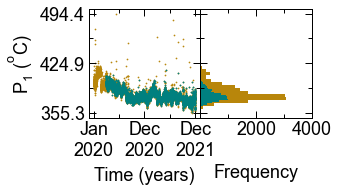

1


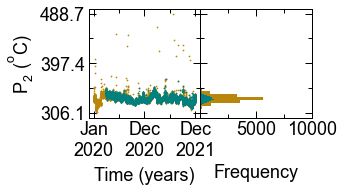

2


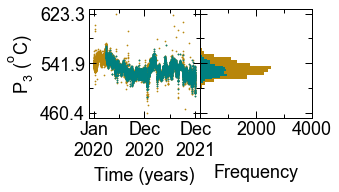

3


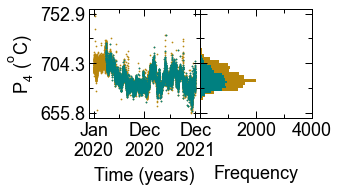

4


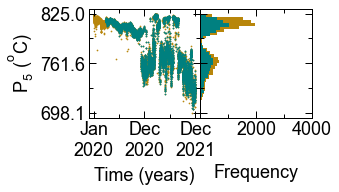

5


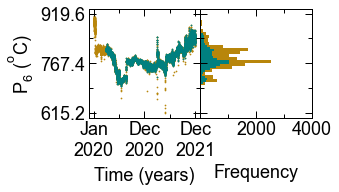

6


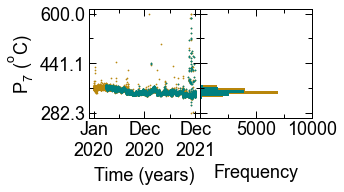

7


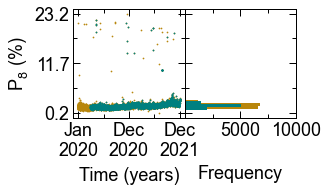

8


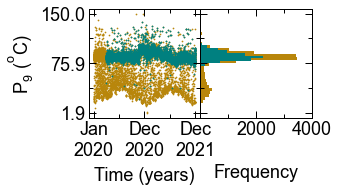

9


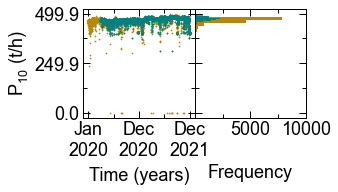

10


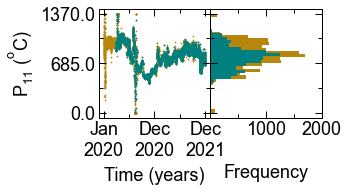

11


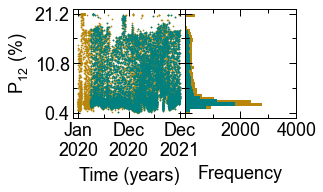

12


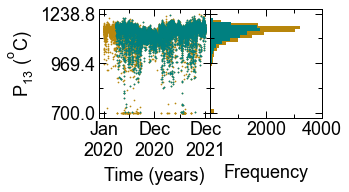

13


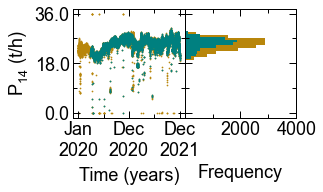

14


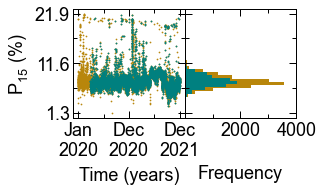

15


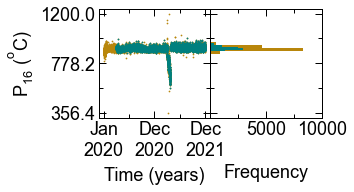

16


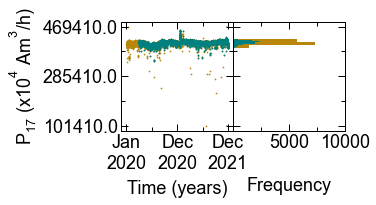

17


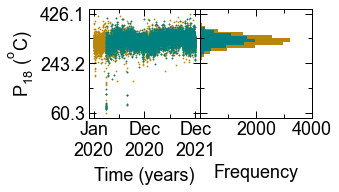

18


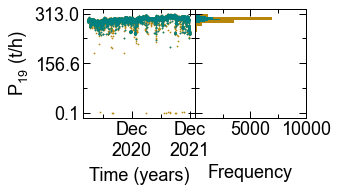

19


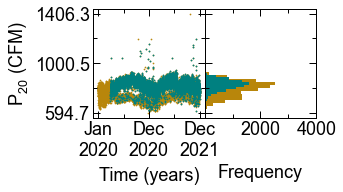

20


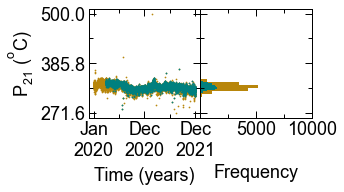

21


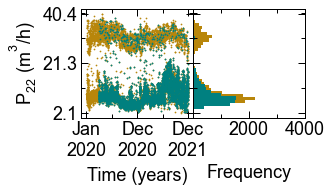

22


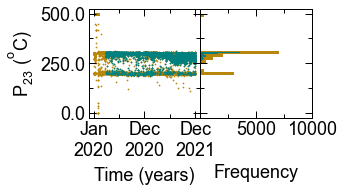

23


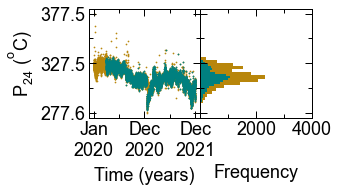

24


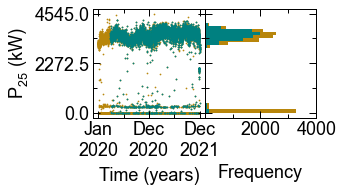

25


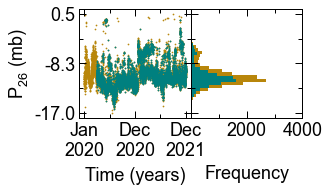

26


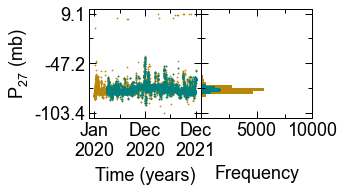

27


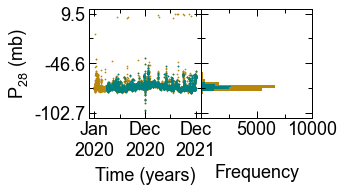

28


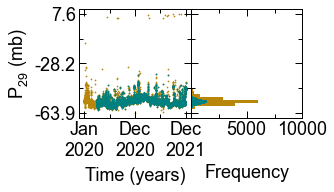

29


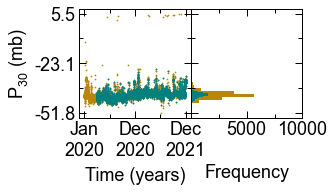

30


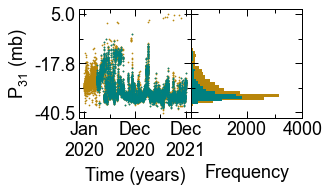

31


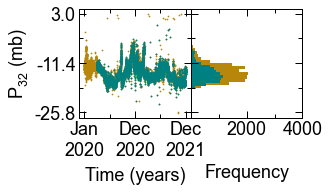

32


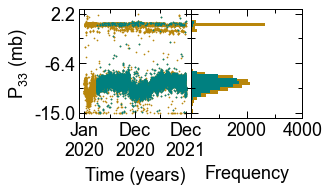

33


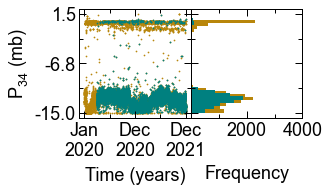

In [186]:
matplotlib.rcParams['axes.linewidth'] = 1
variable = pp.copy(deep= True)
filter_var = pp_filtered.copy(deep= True)
filter_var.reset_index(inplace = True)
x_vals = list(filter_var['index'].values)
filter_var.drop(columns=['index'], inplace = True)
s = 18
n = 0
for column in variable:
    print(n)
    # if column == 'Flue gas O2 content (calciner outlet)':
    #     continue
    fig, ax = plt.subplots(1,2,figsize=(4,2),squeeze = False, sharey='col' )
    plt.subplots_adjust(wspace=0)
    raw = variable[column].values
    # raw = [x for x in raw if not np.isnan(x)]  # removing Nan. Becs they are not plotted
    filtered_raw = filter_var[column].values
    [a, b] = list(variable.describe()[column][['min', 'max']])
    mini,mid, maxi = average(a, b)
    _= ax[0,0].set_yticks([mini,mid, maxi],[mini,mid, maxi],fontsize = s, fontweight = 'normal') 
    _=ax[0,0].set_xlabel('Time (years)', fontweight = 'normal', fontsize = s,labelpad = 7)
    _=ax[0,0].set_xticks([0,len(raw)/2 ,len(raw)], labels = ['Jan\n2020','Dec\n2020' ,'Dec\n2021'], fontsize = s, fontweight= 'normal')
    # _=ax[0,0].plot(np.arange(0,len(raw)), raw, linewidth=1, color= foreground)
    # _=ax[0,0].plot(x_vals, filtered_raw, linewidth=1, color= background)
    _=ax[0,0].scatter(np.arange(0,len(raw)), raw, s=0.5, color= foreground)
    _=ax[0,0].scatter(x_vals, filtered_raw, s=0.5, color= background)

    _= ax[0,0].tick_params(which = 'major', width= 1, length =7)
    _= ax[0,0].tick_params(which = 'minor', width= 1, length =4)
    _= ax[0,0].tick_params(axis='x', direction ='in', which = 'both')
    _= ax[0,0].tick_params(axis='y', direction ='in', which = 'both')
    _= ax[0,0].tick_params(axis='y', which='major', right= True)
    _= ax[0,0].tick_params(axis='y', which='minor', right= True)
    _= ax[0,0].tick_params(axis='y', which='major', left= True)
    _= ax[0,0].tick_params(axis='y', which='minor', left= True)
    _= ax[0,0].tick_params(axis='x', which='major', top = True)
    _= ax[0,0].tick_params(axis='x', which='minor', top = True)
    _= ax[0,0].set_ylabel(pp_naming_list[n], fontsize=s, fontweight='normal') #,labelpad = s


    _= ax[0,1].set_yticks([mini,mid, maxi],[mini,mid, maxi],fontsize = 0, fontweight = 'normal') 
    _= ax[0,1].set_xlabel('Frequency', fontsize=s, fontweight='normal' ,labelpad = 25)
    _= ax[0,1].tick_params(which = 'major', width= 1, length =7)
    _= ax[0,1].tick_params(which = 'minor', width= 1, length =4)
    _= ax[0,1].tick_params(axis='x', direction ='in', which = 'both')
    _= ax[0,1].tick_params(axis='y', direction ='in', which = 'both')
    _= ax[0,1].tick_params(axis='y', which='major', right= True)
    _= ax[0,1].tick_params(axis='y', which='minor', right= True)
    _= ax[0,1].tick_params(axis='y', which='major', left= True)
    _= ax[0,1].tick_params(axis='y', which='minor', left= True)
    _= ax[0,1].tick_params(axis='x', which='major', top = True)
    _= ax[0,1].tick_params(axis='x', which='minor', top = True)
    _ = plt.hist(raw, bins = int(1+3.3*np.log(len(raw))), ec= 'none', color = foreground, density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
    _ = plt.hist(filtered_raw, bins = int(1+3.3*np.log(len(filtered_raw))), ec= 'none', color = background, density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
    maxi = int(np.max(ax[0,1].get_xticks()))
    midi = int(np.max(ax[0,1].get_xticks())/2)
    _= ax[0,1].set_xticks([midi, maxi],[midi, maxi],fontsize = s, fontweight = 'normal') 
    # _= ax[0,1].text(0.32,0.65, f'$\mu$ = {mean}\n$\sigma$ = {SD}',transform=ax[0,1].transAxes ,linespacing=1 ,fontsize=s-1, fontweight='normal') #verticalalignment='bottom'
    plt.savefig(f'/Users/sheikhjunaidfayaz/Documents/saved_items/clinker_phase_prediction_paper/distributions/pp/{n}.tiff',format='tiff', dpi=1200)
    n+=1
    plt.show()
                                            

# Visualizing raw vs filtered hot meal

0


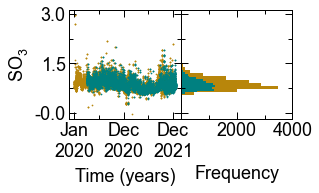

1


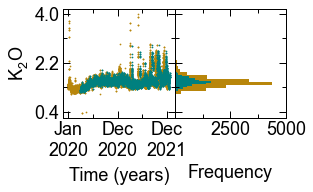

2


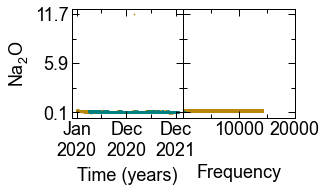

3


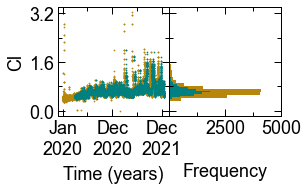

4


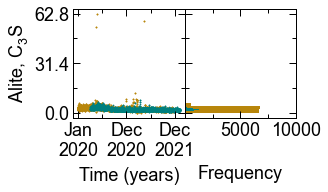

5


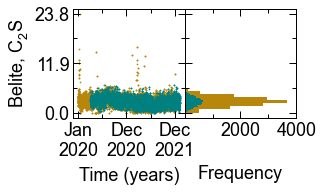

6


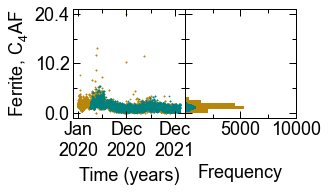

In [189]:
matplotlib.rcParams['axes.linewidth'] = 1
variable = hrm.copy(deep= True)
filter_var = hrm_filtered.copy(deep= True)
filter_var.reset_index(inplace = True)
x_vals = list(filter_var['index'].values)
filter_var.drop(columns=['index'], inplace = True)
s = 18
n = 0
for column in variable:
    print(n)
    # if column == 'Flue gas O2 content (calciner outlet)':
    #     continue
    fig, ax = plt.subplots(1,2,figsize=(4,2),squeeze = False, sharey='col' )
    plt.subplots_adjust(wspace=0)
    raw = variable[column].values
    raw = [x for x in raw if not np.isnan(x)]  # removing Nan. Becs they are not plotted
    filtered_raw = filter_var[column].values
    [a, b] = list(variable.describe()[column][['min', 'max']])
    mini,mid, maxi = average(a, b)
    _= ax[0,0].set_yticks([mini,mid, maxi],[mini,mid, maxi],fontsize = s, fontweight = 'normal') 
    _=ax[0,0].set_xlabel('Time (years)', fontweight = 'normal', fontsize = s,labelpad = 7)
    _=ax[0,0].set_xticks([0,len(raw)/2 ,len(raw)], labels = ['Jan\n2020','Dec\n2020' ,'Dec\n2021'], fontsize = s, fontweight= 'normal')
    # _=ax[0,0].plot(np.arange(0,len(raw)), raw, linewidth=1, color= foreground)
    # _=ax[0,0].plot(x_vals, filtered_raw, linewidth=1, color= background)
    _=ax[0,0].scatter(np.arange(0,len(raw)), raw, s=0.5, color= foreground)
    _=ax[0,0].scatter(x_vals, filtered_raw, s=0.5, color= background)

    _= ax[0,0].tick_params(which = 'major', width= 1, length =7)
    _= ax[0,0].tick_params(which = 'minor', width= 1, length =4)
    _= ax[0,0].tick_params(axis='x', direction ='in', which = 'both')
    _= ax[0,0].tick_params(axis='y', direction ='in', which = 'both')
    _= ax[0,0].tick_params(axis='y', which='major', right= True)
    _= ax[0,0].tick_params(axis='y', which='minor', right= True)
    _= ax[0,0].tick_params(axis='y', which='major', left= True)
    _= ax[0,0].tick_params(axis='y', which='minor', left= True)
    _= ax[0,0].tick_params(axis='x', which='major', top = True)
    _= ax[0,0].tick_params(axis='x', which='minor', top = True)
    _= ax[0,0].set_ylabel(naming_list_hrm[n], fontsize=s, fontweight='normal') #,labelpad = s

    _= ax[0,1].set_yticks([mini,mid, maxi],[mini,mid, maxi],fontsize = 0, fontweight = 'normal') 
    _= ax[0,1].set_xlabel('Frequency', fontsize=s, fontweight='normal' ,labelpad = 25)
    _= ax[0,1].tick_params(which = 'major', width= 1, length =7)
    _= ax[0,1].tick_params(which = 'minor', width= 1, length =4)
    _= ax[0,1].tick_params(axis='x', direction ='in', which = 'both')
    _= ax[0,1].tick_params(axis='y', direction ='in', which = 'both')
    _= ax[0,1].tick_params(axis='y', which='major', right= True)
    _= ax[0,1].tick_params(axis='y', which='minor', right= True)
    _= ax[0,1].tick_params(axis='y', which='major', left= True)
    _= ax[0,1].tick_params(axis='y', which='minor', left= True)
    _= ax[0,1].tick_params(axis='x', which='major', top = True)
    _= ax[0,1].tick_params(axis='x', which='minor', top = True)
    _ = plt.hist(raw, bins = int(1+3.3*np.log(len(raw))), ec= 'none', color = foreground, density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
    _ = plt.hist(filtered_raw, bins = int(1+3.3*np.log(len(filtered_raw))), ec= 'none', color = background, density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
    maxi = int(np.max(ax[0,1].get_xticks()))
    midi = int(np.max(ax[0,1].get_xticks())/2)
    _= ax[0,1].set_xticks([midi, maxi],[midi, maxi],fontsize = s, fontweight = 'normal') 
    # _= ax[0,1].text(0.32,0.65, f'$\mu$ = {mean}\n$\sigma$ = {SD}',transform=ax[0,1].transAxes ,linespacing=1 ,fontsize=s-1, fontweight='normal') #verticalalignment='bottom'
    plt.savefig(f'/Users/sheikhjunaidfayaz/Documents/saved_items/clinker_phase_prediction_paper/distributions/hrm/{n}.tiff',format='tiff', dpi=1200)
    n+=1
    plt.show()
                                            

# Visualizing raw vs filtered kiln feed

0


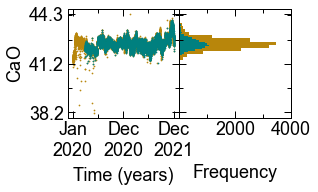

1


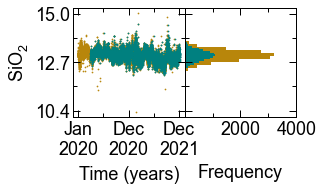

2


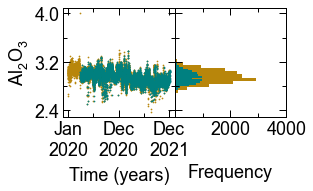

3


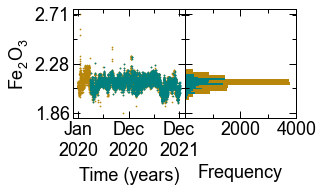

4


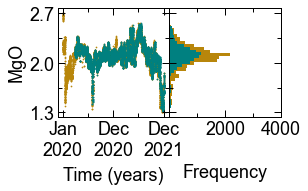

5


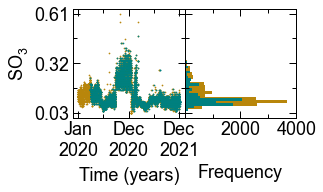

6


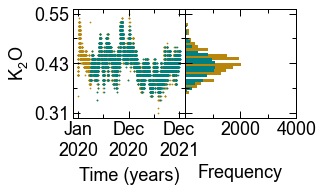

7


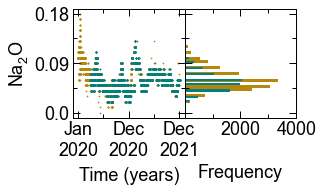

8


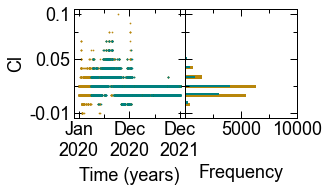

In [190]:
matplotlib.rcParams['axes.linewidth'] = 1
variable = frm.copy(deep= True)
filter_var = frm_filtered.copy(deep= True)
filter_var.reset_index(inplace = True)
x_vals = list(filter_var['index'].values)
filter_var.drop(columns=['index'], inplace = True)
s = 18
n = 0
for column in variable:
    print(n)
    # if column == 'Flue gas O2 content (calciner outlet)':
    #     continue
    fig, ax = plt.subplots(1,2,figsize=(4,2),squeeze = False, sharey='col' )
    plt.subplots_adjust(wspace=0)
    raw = variable[column].values
    raw = [x for x in raw if not np.isnan(x)]  # removing Nan. Becs they are not plotted
    filtered_raw = filter_var[column].values
    [a, b] = list(variable.describe()[column][['min', 'max']])
    mini,mid, maxi = average(a, b)

    _= ax[0,0].set_yticks([mini,mid, maxi],[mini,mid, maxi],fontsize = s, fontweight = 'normal') 
    _=ax[0,0].set_xlabel('Time (years)', fontweight = 'normal', fontsize = s,labelpad = 7)
    _=ax[0,0].set_xticks([0,len(raw)/2 ,len(raw)], labels = ['Jan\n2020','Dec\n2020' ,'Dec\n2021'], fontsize = s, fontweight= 'normal')
    # _=ax[0,0].plot(np.arange(0,len(raw)), raw, linewidth=1, color= foreground)
    # _=ax[0,0].plot(x_vals, filtered_raw, linewidth=1, color= background)
    _=ax[0,0].scatter(np.arange(0,len(raw)), raw, s=0.5, color= foreground)
    _=ax[0,0].scatter(x_vals, filtered_raw, s=0.5, color= background)

    _= ax[0,0].tick_params(which = 'major', width= 1, length =7)
    _= ax[0,0].tick_params(which = 'minor', width= 1, length =4)
    _= ax[0,0].tick_params(axis='x', direction ='in', which = 'both')
    _= ax[0,0].tick_params(axis='y', direction ='in', which = 'both')
    _= ax[0,0].tick_params(axis='y', which='major', right= True)
    _= ax[0,0].tick_params(axis='y', which='minor', right= True)
    _= ax[0,0].tick_params(axis='y', which='major', left= True)
    _= ax[0,0].tick_params(axis='y', which='minor', left= True)
    _= ax[0,0].tick_params(axis='x', which='major', top = True)
    _= ax[0,0].tick_params(axis='x', which='minor', top = True)
    _= ax[0,0].set_ylabel(naming_list_frm[n], fontsize=s, fontweight='normal') #,labelpad = s

    _= ax[0,1].set_yticks([mini,mid, maxi],[mini,mid, maxi],fontsize = 0, fontweight = 'normal') 
    _= ax[0,1].set_xlabel('Frequency', fontsize=s, fontweight='normal' ,labelpad = 25)
    _= ax[0,1].tick_params(which = 'major', width= 1, length =7)
    _= ax[0,1].tick_params(which = 'minor', width= 1, length =4)
    _= ax[0,1].tick_params(axis='x', direction ='in', which = 'both')
    _= ax[0,1].tick_params(axis='y', direction ='in', which = 'both')
    _= ax[0,1].tick_params(axis='y', which='major', right= True)
    _= ax[0,1].tick_params(axis='y', which='minor', right= True)
    _= ax[0,1].tick_params(axis='y', which='major', left= True)
    _= ax[0,1].tick_params(axis='y', which='minor', left= True)
    _= ax[0,1].tick_params(axis='x', which='major', top = True)
    _= ax[0,1].tick_params(axis='x', which='minor', top = True)
    _ = plt.hist(raw, bins = int(1+3.3*np.log(len(raw))), ec= 'none', color = foreground, density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
    _ = plt.hist(filtered_raw, bins = int(1+3.3*np.log(len(filtered_raw))), ec= 'none', color = background, density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
    maxi = int(np.max(ax[0,1].get_xticks()))
    midi = int(np.max(ax[0,1].get_xticks())/2)
    _= ax[0,1].set_xticks([midi, maxi],[midi, maxi],fontsize = s, fontweight = 'normal') 
    # _= ax[0,1].text(0.32,0.65, f'$\mu$ = {mean}\n$\sigma$ = {SD}',transform=ax[0,1].transAxes ,linespacing=1 ,fontsize=s-1, fontweight='normal') #verticalalignment='bottom'
    plt.savefig(f'/Users/sheikhjunaidfayaz/Documents/saved_items/clinker_phase_prediction_paper/distributions/frm/{n}.tiff',format='tiff', dpi=1200)
    n+=1
    plt.show()

# Visualizing raw vs filtered clinker composition

0


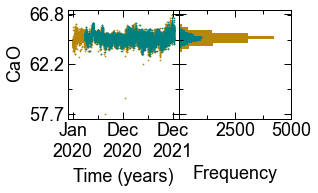

1


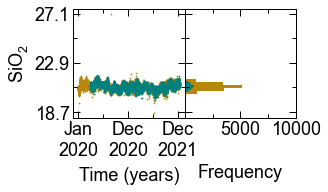

2


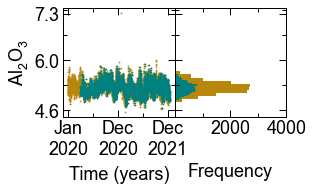

3


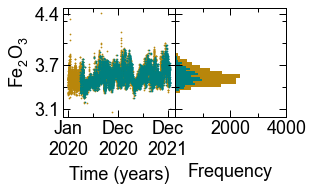

4


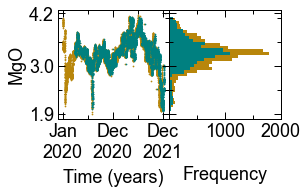

5


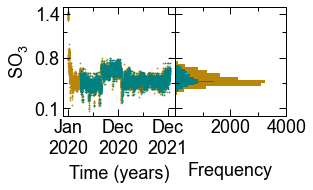

6


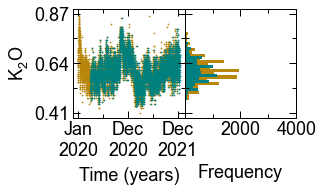

7


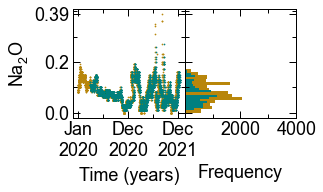

8


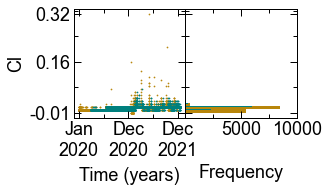

9


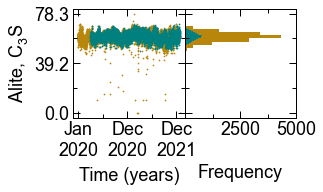

10


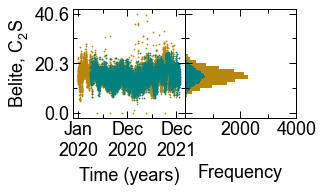

11


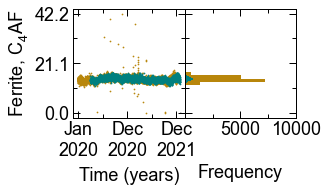

In [191]:
matplotlib.rcParams['axes.linewidth'] = 1
variable = clinker.copy(deep= True)
filter_var = clinker_filtered.copy(deep= True)
filter_var.reset_index(inplace = True)
x_vals = list(filter_var['index'].values)
filter_var.drop(columns=['index'], inplace = True)
s = 18
n = 0
for column in variable:
    print(n)
    # if column == 'Flue gas O2 content (calciner outlet)':
    #     continue
    fig, ax = plt.subplots(1,2,figsize=(4,2),squeeze = False, sharey='col' )
    plt.subplots_adjust(wspace=0)
    raw = variable[column].values
    raw = [x for x in raw if not np.isnan(x)]  # removing Nan. Becs they are not plotted
    filtered_raw = filter_var[column].values
    [a, b] = list(variable.describe()[column][['min', 'max']])
    mini,mid, maxi = average(a, b)
    _= ax[0,0].set_yticks([mini,mid, maxi],[mini,mid, maxi],fontsize = s, fontweight = 'normal') 
    _=ax[0,0].set_xlabel('Time (years)', fontweight = 'normal', fontsize = s,labelpad = 7)
    _=ax[0,0].set_xticks([0,len(raw)/2 ,len(raw)], labels = ['Jan\n2020','Dec\n2020' ,'Dec\n2021'], fontsize = s, fontweight= 'normal')
    # _=ax[0,0].plot(np.arange(0,len(raw)), raw, linewidth=1, color= foreground)
    # _=ax[0,0].plot(x_vals, filtered_raw, linewidth=1, color= background)
    _=ax[0,0].scatter(np.arange(0,len(raw)), raw, s=0.5, color= foreground)
    _=ax[0,0].scatter(x_vals, filtered_raw, s=0.5, color= background)

    _= ax[0,0].tick_params(which = 'major', width= 1, length =7)
    _= ax[0,0].tick_params(which = 'minor', width= 1, length =4)
    _= ax[0,0].tick_params(axis='x', direction ='in', which = 'both')
    _= ax[0,0].tick_params(axis='y', direction ='in', which = 'both')
    _= ax[0,0].tick_params(axis='y', which='major', right= True)
    _= ax[0,0].tick_params(axis='y', which='minor', right= True)
    _= ax[0,0].tick_params(axis='y', which='major', left= True)
    _= ax[0,0].tick_params(axis='y', which='minor', left= True)
    _= ax[0,0].tick_params(axis='x', which='major', top = True)
    _= ax[0,0].tick_params(axis='x', which='minor', top = True)
    _= ax[0,0].set_ylabel(naming_list_clk[n], fontsize=s, fontweight='normal') #,labelpad = s

    _= ax[0,1].set_yticks([mini,mid, maxi],[mini,mid, maxi],fontsize = 0, fontweight = 'normal') 
    _= ax[0,1].set_xlabel('Frequency', fontsize=s, fontweight='normal' ,labelpad = 25)
    _= ax[0,1].tick_params(which = 'major', width= 1, length =7)
    _= ax[0,1].tick_params(which = 'minor', width= 1, length =4)
    _= ax[0,1].tick_params(axis='x', direction ='in', which = 'both')
    _= ax[0,1].tick_params(axis='y', direction ='in', which = 'both')
    _= ax[0,1].tick_params(axis='y', which='major', right= True)
    _= ax[0,1].tick_params(axis='y', which='minor', right= True)
    _= ax[0,1].tick_params(axis='y', which='major', left= True)
    _= ax[0,1].tick_params(axis='y', which='minor', left= True)
    _= ax[0,1].tick_params(axis='x', which='major', top = True)
    _= ax[0,1].tick_params(axis='x', which='minor', top = True)
    _ = plt.hist(raw, bins = int(1+3.3*np.log(len(raw))), ec= 'none', color = foreground, density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
    _ = plt.hist(filtered_raw, bins = int(1+3.3*np.log(len(filtered_raw))), ec= 'none', color = background, density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
    maxi = int(np.max(ax[0,1].get_xticks()))
    midi = int(np.max(ax[0,1].get_xticks())/2)
    _= ax[0,1].set_xticks([midi, maxi],[midi, maxi],fontsize = s, fontweight = 'normal') 
    # _= ax[0,1].text(0.32,0.65, f'$\mu$ = {mean}\n$\sigma$ = {SD}',transform=ax[0,1].transAxes ,linespacing=1 ,fontsize=s-1, fontweight='normal') #verticalalignment='bottom'
    plt.savefig(f'/Users/sheikhjunaidfayaz/Documents/saved_items/clinker_phase_prediction_paper/distributions/clinker/{n}.tiff',format='tiff', dpi=1200)
    n+=1
    plt.show()